# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal 
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [2]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `tf.keras` framework.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [4]:
PATH  = "/Users/simoneboesso/Desktop/RemoteSensing/Semantic segmentation dataset/"

In [5]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

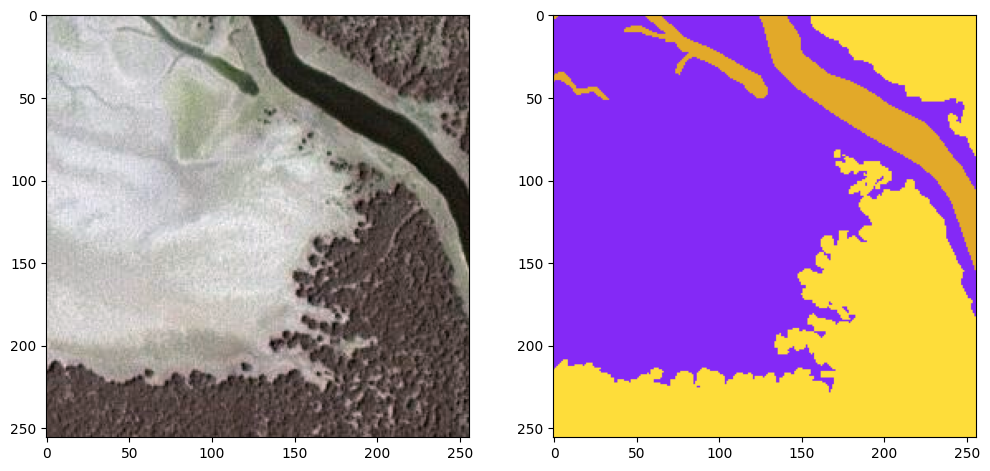

In [6]:
PATCH_GENERATOR.check()

In [7]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels


In [8]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [9]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [10]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [11]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [12]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


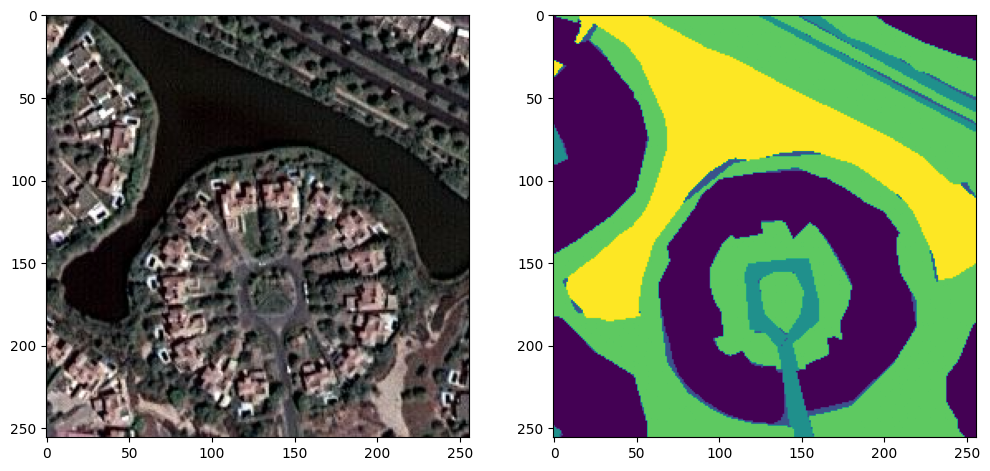

In [13]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Modelling section

In [14]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

## NEXT STEPS:

- Grid search for hyperparameter tuning following university procedure;
- review U-net concepts
- compare with other pretrained models


# Choosing hyperparameters

1. Check initial Loss (Turn off weight decay, sanity check loss at initialization)
2. Overfit a small sample (try to train to 100% training accuracy on a small sample of training data, approx. 5-10 minibatches)
    1. Fiddle with architecture, learning rate, weight initialization;
    2. some common problems:
        1. Loss is not going down: LR too low, or bad initialization;
        2. Loss explodes to Inf or Nan: LR too high, bad initialization
3. Use all the training data, turn on small weight decay, find the learning rate that makes the loss drop significantly  withing 100 iterations ( use the same architecture obtained in the previous step);
    1. good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4
4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs
    1. good weight decay to try: 1e-4, 1e-5, 0
5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.
6. Measure their performances using loss and accuracy curves
7. Go back to step 5 if needed (refine grid search)

In [16]:
import wandb
!wandb login 
# https://docs.wandb.ai/quickstart

wandb: Appending key for api.wandb.ai to your netrc file: /Users/simoneboesso/.netrc


In [25]:
_, sample_imgs, y_, sample_labels = train_test_split(X_train, y_train, test_size = 0.005, random_state = 42)

In [28]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef  

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]



1. Check initial loss

In [ ]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=1, 
                    shuffle=False)

2. Overfit a small sample

In [26]:
sample_imgs.shape

(6, 256, 256, 3)

In [ ]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history2 = model.fit(sample_imgs, sample_labels, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=300, 
                    shuffle=False)

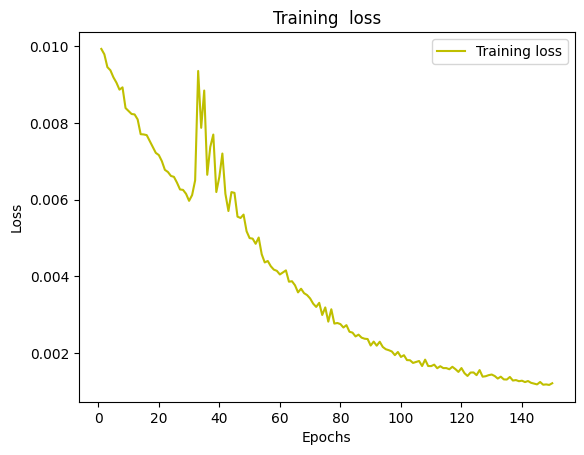

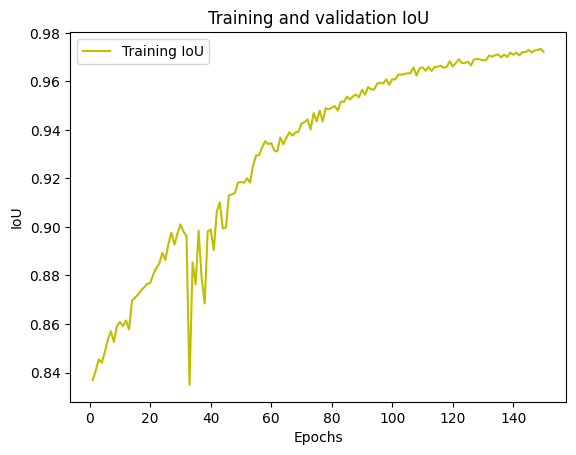

In [34]:
history = history2
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

3. Grid-Search (for 100 iterations)

In [ ]:
!pip install --upgrade adapt

In [18]:
!which python 

/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/bin/python


In [ ]:
! conda list

In [21]:
!python -V

Python 3.11.9


In [ ]:
!pip install scikit-learn==1.4.2 scikeras==0.13.0


In [17]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [18]:
X_train.shape

(1044, 256, 256, 3)

In [19]:
# Assuming you have 1000 samples
n_samples = 1044
batch_size = 32

print("the total number of iterations in a epoch is", n_samples/batch_size)
total_iterations = 100

the total number of iterations in a epoch is 32.625


In [38]:
def define_model(learning_rate = 0.01):
    model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
    return model

In [22]:
# Initialize W&B
wandb.init(project="FirstGridSearch")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: boesso-simone (simboex). Use `wandb login --relogin` to force relogin


In [ ]:
!conda install -c anaconda wandb -y

In [42]:
from wandb.keras import WandbCallback
# Add a custom fit method to include W&B callback
class WandbKerasClassifier(KerasClassifier):
    def fit(self, x, y, **kwargs):
        # Extract the parameters
        learning_rate = kwargs.pop('learning_rate', 0.001)
        optimizer = kwargs.pop('optimizer', "adam")

        # Log the hyperparameters
        wandb.config.update({
            'learning_rate': learning_rate,
            'optimizer': optimizer,
        })

        return super().fit(x, y, **kwargs, callbacks=[WandbCallback()])
    
model = WandbKerasClassifier(build_fn=define_model, verbose=1, epochs=3, loss=sm.losses.CategoricalFocalLoss(),batch_size = 32)


In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]
optimizer = ['SGD', 'RMSprop', 'Adam']
param_grid = {'optimizer__learning_rate': [0.05, 0.1],
              "optimizer":optimizer,
            }
grid = GridSearchCV(estimator=model, param_grid=param_grid,  verbose = 1,n_jobs=1, cv=1)

grid_result = grid.fit(X_train, y_train)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))